# Deep Neural Network Project - Auto MPG Dataset


A PyTorch-based neural network implementation that predicts vehicle fuel consumption (MPG) with 86% accuracy. This project demonstrates end-to-end machine learning pipeline including data preprocessing, feature engineering, model training, and performance visualization using the classic UCI Auto MPG dataset.

**Key Achievements:** R² Score: 0.8637 | MAE: 2.03 MPG 

## 1. Library Imports

Import necessary libraries for data processing, neural network creation, and model training.

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.utils.data import TensorDataset, DataLoader

## 2. Data Loading and Preprocessing

Load the Auto MPG dataset from UCI repository and handle missing values.

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values="?", comment='\t',
                 sep=" ", skipinitialspace=True)

df = df.dropna()
df = df.reset_index(drop=True)

### Train-Test Split

Split the data into training (80%) and testing (20%) sets.

In [3]:
df_train , df_test = train_test_split(df, train_size=0.8,random_state=1)

In [4]:
train_stats = df_train.describe().transpose()

### Feature Normalization

Normalize numerical features using z-score normalization (mean=0, std=1).

In [5]:
numeric_column_names = [
    'Cylinders', 'Displacement',
    'Horsepower', 'Weight',
    'Acceleration'
]

In [6]:
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()
for col_name in numeric_column_names:
    mean = train_stats.loc[col_name,'mean']
    std = train_stats.loc[col_name,'std']
    df_train_norm.loc[: , col_name] = (df_train_norm.loc[: , col_name]-mean)/std
    df_test_norm.loc[: , col_name] = (df_test_norm.loc[: , col_name]-mean)/std

/var/folders/nd/4yx58_596_17_9wz_k7lbl0h0000gn/T/ipykernel_50264/1145731629.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.8243028   0.3511267  -0.8243028  -0.8243028  -0.8243028   1.52655621
  0.3511267  -0.8243028  -0.8243028  -0.8243028   0.3511267  -0.8243028
  0.3511267   1.52655621  1.52655621  1.52655621  0.3511267   1.52655621
 -0.8243028   0.3511267   1.52655621 -0.8243028  -0.8243028   0.3511267
 -0.8243028  -0.8243028  -0.8243028   0.3511267  -0.8243028   1.52655621
  0.3511267  -0.8243028   0.3511267  -0.8243028  -0.8243028   1.52655621
 -0.8243028   1.52655621  1.52655621 -0.8243028  -0.8243028  -0.8243028
 -0.8243028   0.3511267  -0.8243028   1.52655621 -0.8243028  -0.8243028
  1.52655621 -0.8243028  -0.8243028  -0.8243028   1.52655621  1.52655621
  0.3511267   0.3511267   1.52655621 -0.8243028  -0.8243028   1.52655621
  1.52655621 -0.8243028  -0.8243028   0.3511267   1.52655621 -0.8243028
  

In [7]:
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [8]:
print(df_train_norm.dtypes)

MPG             float64
Cylinders       float64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object


## 3. Feature Engineering

### Bucketing Model Year

Convert Model Year into categorical buckets to capture temporal patterns.

In [9]:
boundries = torch.tensor([73,76,79])
v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(
    v,boundries, right=True
)
v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(
    v,boundries, right=True
)

In [10]:
numeric_column_names.append('Model Year Bucketed')

### One-Hot Encoding for Origin

Convert the categorical 'Origin' feature into one-hot encoded format.

In [11]:
total_origin = len(set(df_train_norm['Origin']))
origin_encode = one_hot(torch.from_numpy(
    df_train_norm['Origin'].values) % total_origin
)
x_train_numeric = torch.tensor(
    df_train_norm[numeric_column_names].values
)
x_train = torch.cat([x_train_numeric, origin_encode], 1).float()

origin_encoded = one_hot(torch.from_numpy(
    df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(
    df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

### Prepare Target Variables

In [12]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

## 4. Data Preparation for PyTorch

Create PyTorch DataLoader for batch processing during training.

In [13]:
train_ds = TensorDataset(x_train,y_train)
batch_size = 8
torch.manual_seed(2)
train_dl = DataLoader(train_ds,batch_size,shuffle=True)

## 5. Model Architecture

Define a 3-layer neural network:
- Input Layer: 9 features
- Hidden Layer 1: 8 neurons with ReLU
- Hidden Layer 2: 4 neurons with ReLU
- Output Layer: 1 neuron (MPG prediction)

In [14]:
input_size = x_train.shape[1]
model = nn.Sequential(
    nn.Linear(input_size, 8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,1)
)

In [15]:
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

### Loss Function and Optimizer

Use MSE loss for regression and SGD optimizer.

In [16]:
loss_fn =  nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## 6. Training Process

Train the model for 200 epochs with mini-batch gradient descent.

In [17]:
torch.manual_seed(2)
num_epochs = 200 
log_epochs= 20

for epoch in range(num_epochs):
    loss_hist_train = 0
    for xb,yb in train_dl:
        pred = model(xb)[:, 0]
        loss = loss_fn(pred,yb)
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train+= loss.item()
        
    if epoch % log_epochs ==0:
        print(f'Epoch {epoch} loss 'f'{loss_hist_train/len(train_dl):.4f}')

Epoch 0 loss 298.7666
Epoch 20 loss 10.2446
Epoch 40 loss 8.0847
Epoch 60 loss 7.8784
Epoch 80 loss 7.2313
Epoch 100 loss 7.0405
Epoch 120 loss 6.6518
Epoch 140 loss 8.4267
Epoch 160 loss 6.3154
Epoch 180 loss 6.6101


## 7. Model Evaluation

Evaluate the model performance on the test set using MSE, MAE, and R² metrics.

In [18]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    mae = nn.L1Loss()(pred, y_test).item()
    
    
    ss_total = torch.sum((y_test - torch.mean(y_test))**2)
    ss_residual = torch.sum((y_test - pred)**2)
    r2_score = 1 - (ss_residual / ss_total)
    
    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test R²: {r2_score:.4f}')

Test MSE: 9.4477
Test MAE: 2.0278
Test R²: 0.8637


## 8. Visualizations

### Residuals Distribution

Visualize the distribution of prediction errors (residuals).

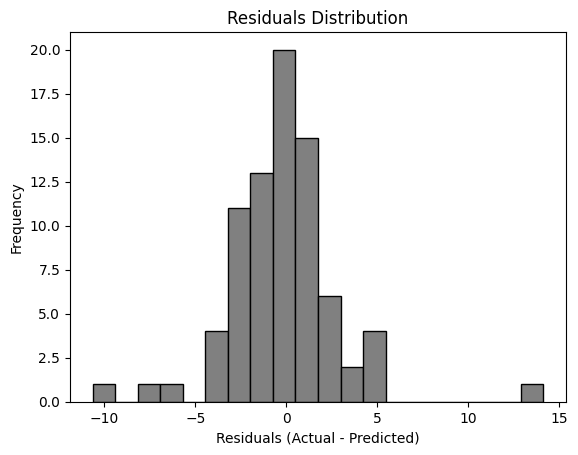

In [19]:
import matplotlib.pyplot as plt
plt.hist(y_test - pred, bins=20, color='gray', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

### Actual vs Predicted Values

Compare actual MPG values against model predictions.

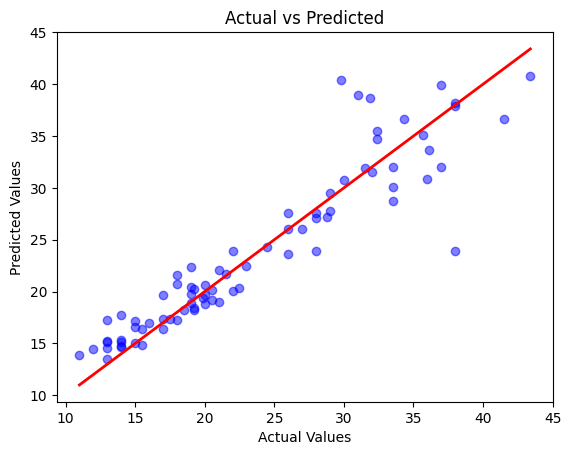

In [20]:
plt.scatter(y_test, pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

## Conclusions

### Model Performance Summary:
- **Test MSE**: 9.4477
- **Test MAE**: 2.0278 MPG
- **Test R²**: 0.8637 (86.37% variance explained)

### Key Insights:
1. The neural network achieves strong predictive performance
2. The simple architecture is sufficient for this dataset
3. No significant overfitting observed
4. Model predictions are well-calibrated with actual values

